In [1]:
import os
import numpy as np 
import pandas as pd
from scipy import stats, signal, io
import mne
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout
import mne_bids
import scipy
#import settings
import json
#from coordinates_io import BIDS_coord
from sklearn import linear_model, metrics
import multiprocessing
from sklearn.model_selection import cross_val_score
from sklearn import ensemble, model_selection
from matplotlib import pyplot as plt
import matplotlib 

In [2]:
BIDS_path = 'C:\\Users\\ICN_admin\\Documents\\BIDS\\'
#out_path = 'C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\Figure 2\\LM_100ms\\'
out_path = 'C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\dat\\'
subject_id = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']

def read_BIDS_file(vhdr_file):
    """
    Read one run file from BIDS standard
    :param vhdr_file: 
    :return: raw dataset array, channel name array
    """
    bv_file = mne_bids.read.io.brainvision.read_raw_brainvision(vhdr_file)
    bv_raw = bv_file.get_data()
    return bv_raw, bv_file.ch_names

def get_all_files_of_type(BIDS_path, type_='.vhdr'):
    """
    
    Given a BIDS path return all vhdr file paths without BIDS_Layout
    Args:
        BIDS_path (string)
    Returns: 
        vhdr_files (list)
    """
    vhdr_files = []
    for root, dirs, files in os.walk(BIDS_path):
        for file in files:
            if file.endswith(type_):
                vhdr_files.append(os.path.join(root, file))
    return vhdr_files


In [3]:
vhdr_files = get_all_files_of_type(BIDS_path, '.vhdr')
tsv_files = get_all_files_of_type(BIDS_path, '.tsv')

In [4]:
def get_best(dict_ch, Con=True, ECOG=True, get_weights=True, get_data=False, measure='R2'):
    """
    return best channel name, best channel performance, and respective weights
    """
    channels = list(dict_ch.keys())
    if ECOG is True:
        list_ch = [ch for ch in channels if 'ECOG' in ch]
        num_ch = len(list_ch)
    else:
        list_ch = [ch for ch in channels if 'STN' in ch]
        num_ch = len(list_ch)

    if num_ch == 0:
        raise ValueError

    
    acc_ = np.zeros(num_ch)
    mov_idx_ = np.zeros(num_ch)
    counter_ch = 0

    for ch_idx, ch  in enumerate(channels):
        if ECOG is True and 'STN' in ch:
            continue
        elif ECOG is False and 'ECOG' in ch:
            continue
        mov_channels = dict_ch[channels[ch_idx]]["mov_ch"]
        mov_idx = get_movement_idx(channels[ch_idx], mov_channels, Con)
        acc_[counter_ch] = dict_ch[channels[ch_idx]]['res_'+mov_channels[mov_idx]][measure]
        mov_idx_[counter_ch] = mov_idx
        counter_ch += 1

    best_ch_idx = np.argmax(acc_)
    mov_idx_best = int(mov_idx_[best_ch_idx])
    best_ch = list_ch[best_ch_idx]; best_acc = np.max(acc_)
    if get_weights is False:
        if get_data is False:
            return best_ch, best_acc
        else:
            return best_ch, best_acc, np.array(dict_ch[best_ch]['data']), \
                                       np.array(dict_ch[best_ch]['true_movements'])[mov_idx_best,:]
    best_weights = dict_ch[channels[best_ch_idx]]['res_'+mov_channels[mov_idx_best]]['weight_'+mov_channels[mov_idx_best]]
    return best_ch, best_acc, best_weights

In [5]:
def get_best_weights_single_time_point(out_path):
    weights_ecog_con = []; weights_ecog_ips = []
    weights_stn_con = []; weights_stn_ips = []

    for sub_idx, subject_id_ in enumerate(subject_id):

        with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
            dict_ch = json.load(fp)

        weights_ecog_con.append(get_best(dict_ch, Con=True, ECOG=True)[2])
        weights_ecog_ips.append(get_best(dict_ch, Con=False, ECOG=True)[2])
        try:
            weights_stn_con.append(get_best(dict_ch, Con=True, ECOG=False)[2])
            weights_stn_ips.append(get_best(dict_ch, Con=False, ECOG=False)[2])
        except ValueError:  # no STN here
            pass
    return np.array(weights_ecog_con), np.array(weights_ecog_ips), np.array(weights_stn_con), np.array(weights_stn_ips)


In [6]:
def get_x_y_c(dict_ch, ind_, Con=True, return_z=False):
    
    channels = list(dict_ch.keys())
    x_choord = np.zeros(len(ind_))
    y_choord = np.zeros(len(ind_))
    z_choord = np.zeros(len(ind_))
    c_ = np.zeros(len(ind_))
    for idx, ind_ch in enumerate(ind_): 
        choord = np.squeeze(np.array(dict_ch[channels[ind_ch]]["choords"]))
        x_choord[idx] = choord[0]
        y_choord[idx] = choord[1]
        z_choord[idx] = choord[2]
        
        #wähle den contralateralen channel aus
        mov_channels = dict_ch[channels[ind_ch]]['mov_ch']

        mov_idx = get_movement_idx(channels[ind_ch], mov_channels, Con)

        c_[idx] = dict_ch[channels[ind_ch]]["res_"+mov_channels[mov_idx]]["R2"]
    if return_z is True:
        return x_choord, y_choord, z_choord, c_
    return x_choord, y_choord, c_

In [7]:
def get_movement_idx(ch, mov_channels, Con=True):
    mov_idx = 0
    if len(mov_channels) > 1:    
        if Con is True:
            if ("RIGHT" in ch and "LEFT" in mov_channels[0]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "LEFT" in mov_channels[1]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[1]):
                mov_idx = 1
        else:
            if ("RIGHT" in ch and "RIGHT" in mov_channels[0]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "RIGHT" in mov_channels[1]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[1]):
                mov_idx = 1
    return mov_idx

In [8]:
def get_best(dict_ch, Con=True, ECOG=True, get_weights=True, get_data=False, measure='R2'):
    """
    return best channel name, best channel performance, and respective weights
    """
    channels = list(dict_ch.keys())
    if ECOG is True:
        list_ch = [ch for ch in channels if 'ECOG' in ch]
        num_ch = len(list_ch)
    else:
        list_ch = [ch for ch in channels if 'STN' in ch]
        num_ch = len(list_ch)

    if num_ch == 0:
        raise ValueError

    
    acc_ = np.zeros(num_ch)
    mov_idx_ = np.zeros(num_ch)
    counter_ch = 0

    for ch_idx, ch  in enumerate(channels):
        try:
            if ECOG is True and 'STN' in ch:
                continue
            elif ECOG is False and 'ECOG' in ch:
                continue
            mov_channels = dict_ch[channels[ch_idx]]["mov_ch"]
            mov_idx = get_movement_idx(channels[ch_idx], mov_channels, Con)
            acc_[counter_ch] = dict_ch[channels[ch_idx]]['res_'+mov_channels[mov_idx]][measure]
            mov_idx_[counter_ch] = mov_idx
            counter_ch += 1
        except:
            continue

    best_ch_idx = np.argmax(acc_)
    mov_idx_best = int(mov_idx_[best_ch_idx])
    best_ch = list_ch[best_ch_idx]; best_acc = np.max(acc_)
    if get_weights is False:
        if get_data is False:
            return best_ch, best_acc
        else:
            return best_ch, best_acc, np.array(dict_ch[best_ch]['data']), \
                                       np.array(dict_ch[best_ch]['true_movements'])[mov_idx_best,:]
    best_weights = dict_ch[channels[best_ch_idx]]['res_'+mov_channels[mov_idx_best]]['weight_'+mov_channels[mov_idx_best]]
    return best_ch, best_acc, best_weights

In [9]:
def get_res(Con = True, ECOG=True):
    res_ = []; res_weights = []
    for subject_id_ in subject_id:
        with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
            dict_ch = json.load(fp)

        best_ch, best_acc, dat, mov = \
            get_best(dict_ch, Con=Con, ECOG=ECOG, get_weights=False, get_data=True, measure='R2')
        out_ = np.zeros([10,8])
        out_weight = np.zeros([10,8])
        for time_shift in np.arange(0,10,1):
            for f_band in range(8):
                if time_shift != 0:
                    y = mov[:-time_shift]
                else:
                    y = mov
                X = dat[f_band,time_shift:]
                try:
                    out_[time_shift, f_band] = \
                        np.mean(cross_val_score(linear_model.LinearRegression(), np.expand_dims(X, axis=1), y>0, \
                        scoring='roc_auc', cv=5, n_jobs=40))
                    out_weight[time_shift, f_band] = linear_model.LinearRegression().fit(np.expand_dims(X, axis=1), y>0).coef_[0]
                except:
                    print('no mov > 0 in label')
                    out_[time_shift, f_band] = 0.5
        res_.append(out_); res_weights.append(out_weight)
    return np.array(res_), np.array(res_weights)


In [ ]:
ECOG_CON, ECOG_CON_weight = get_res(True, True)
ECOG_IPS, ECOG_IPS_weight = get_res(False, True)
STN_CON, STN_CON_weight = get_res(True, False)
STN_IPS, STN_IPS_weight = get_res(False, False)

no mov > 0 in label
no mov > 0 in label
no mov > 0 in label
no mov > 0 in label
no mov > 0 in label
no mov > 0 in label


In [ ]:
np.save(ECOG_CON_weight, "2A_ECOG_CON_weight")

In [ ]:
def plot_weights(arr, title_, cmap=False):
    plt.imshow(arr) #cmap='seismic')
    plt.clim(-0.1, 0.25)
    plt.xticks(np.arange(10), ['0', '-100', '-200', '-300', '-400', '-500', '-600', '-700', '-800', '-900'], 
              rotation=45, horizontalalignment = 'center')
    plt.yticks(np.arange(8), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
    plt.xlabel('Time [ms]')
    plt.ylabel('Frequency Band')
    #cbar = plt.colorbar()
    #cbar.set_label('Weight')
    plt.xlim(-0.5, 9.5)
    plt.ylim(-0.5, 7.5)
    plt.gca().invert_xaxis()
    #plt.gca().invert_yaxis()
    plt.title(title_)

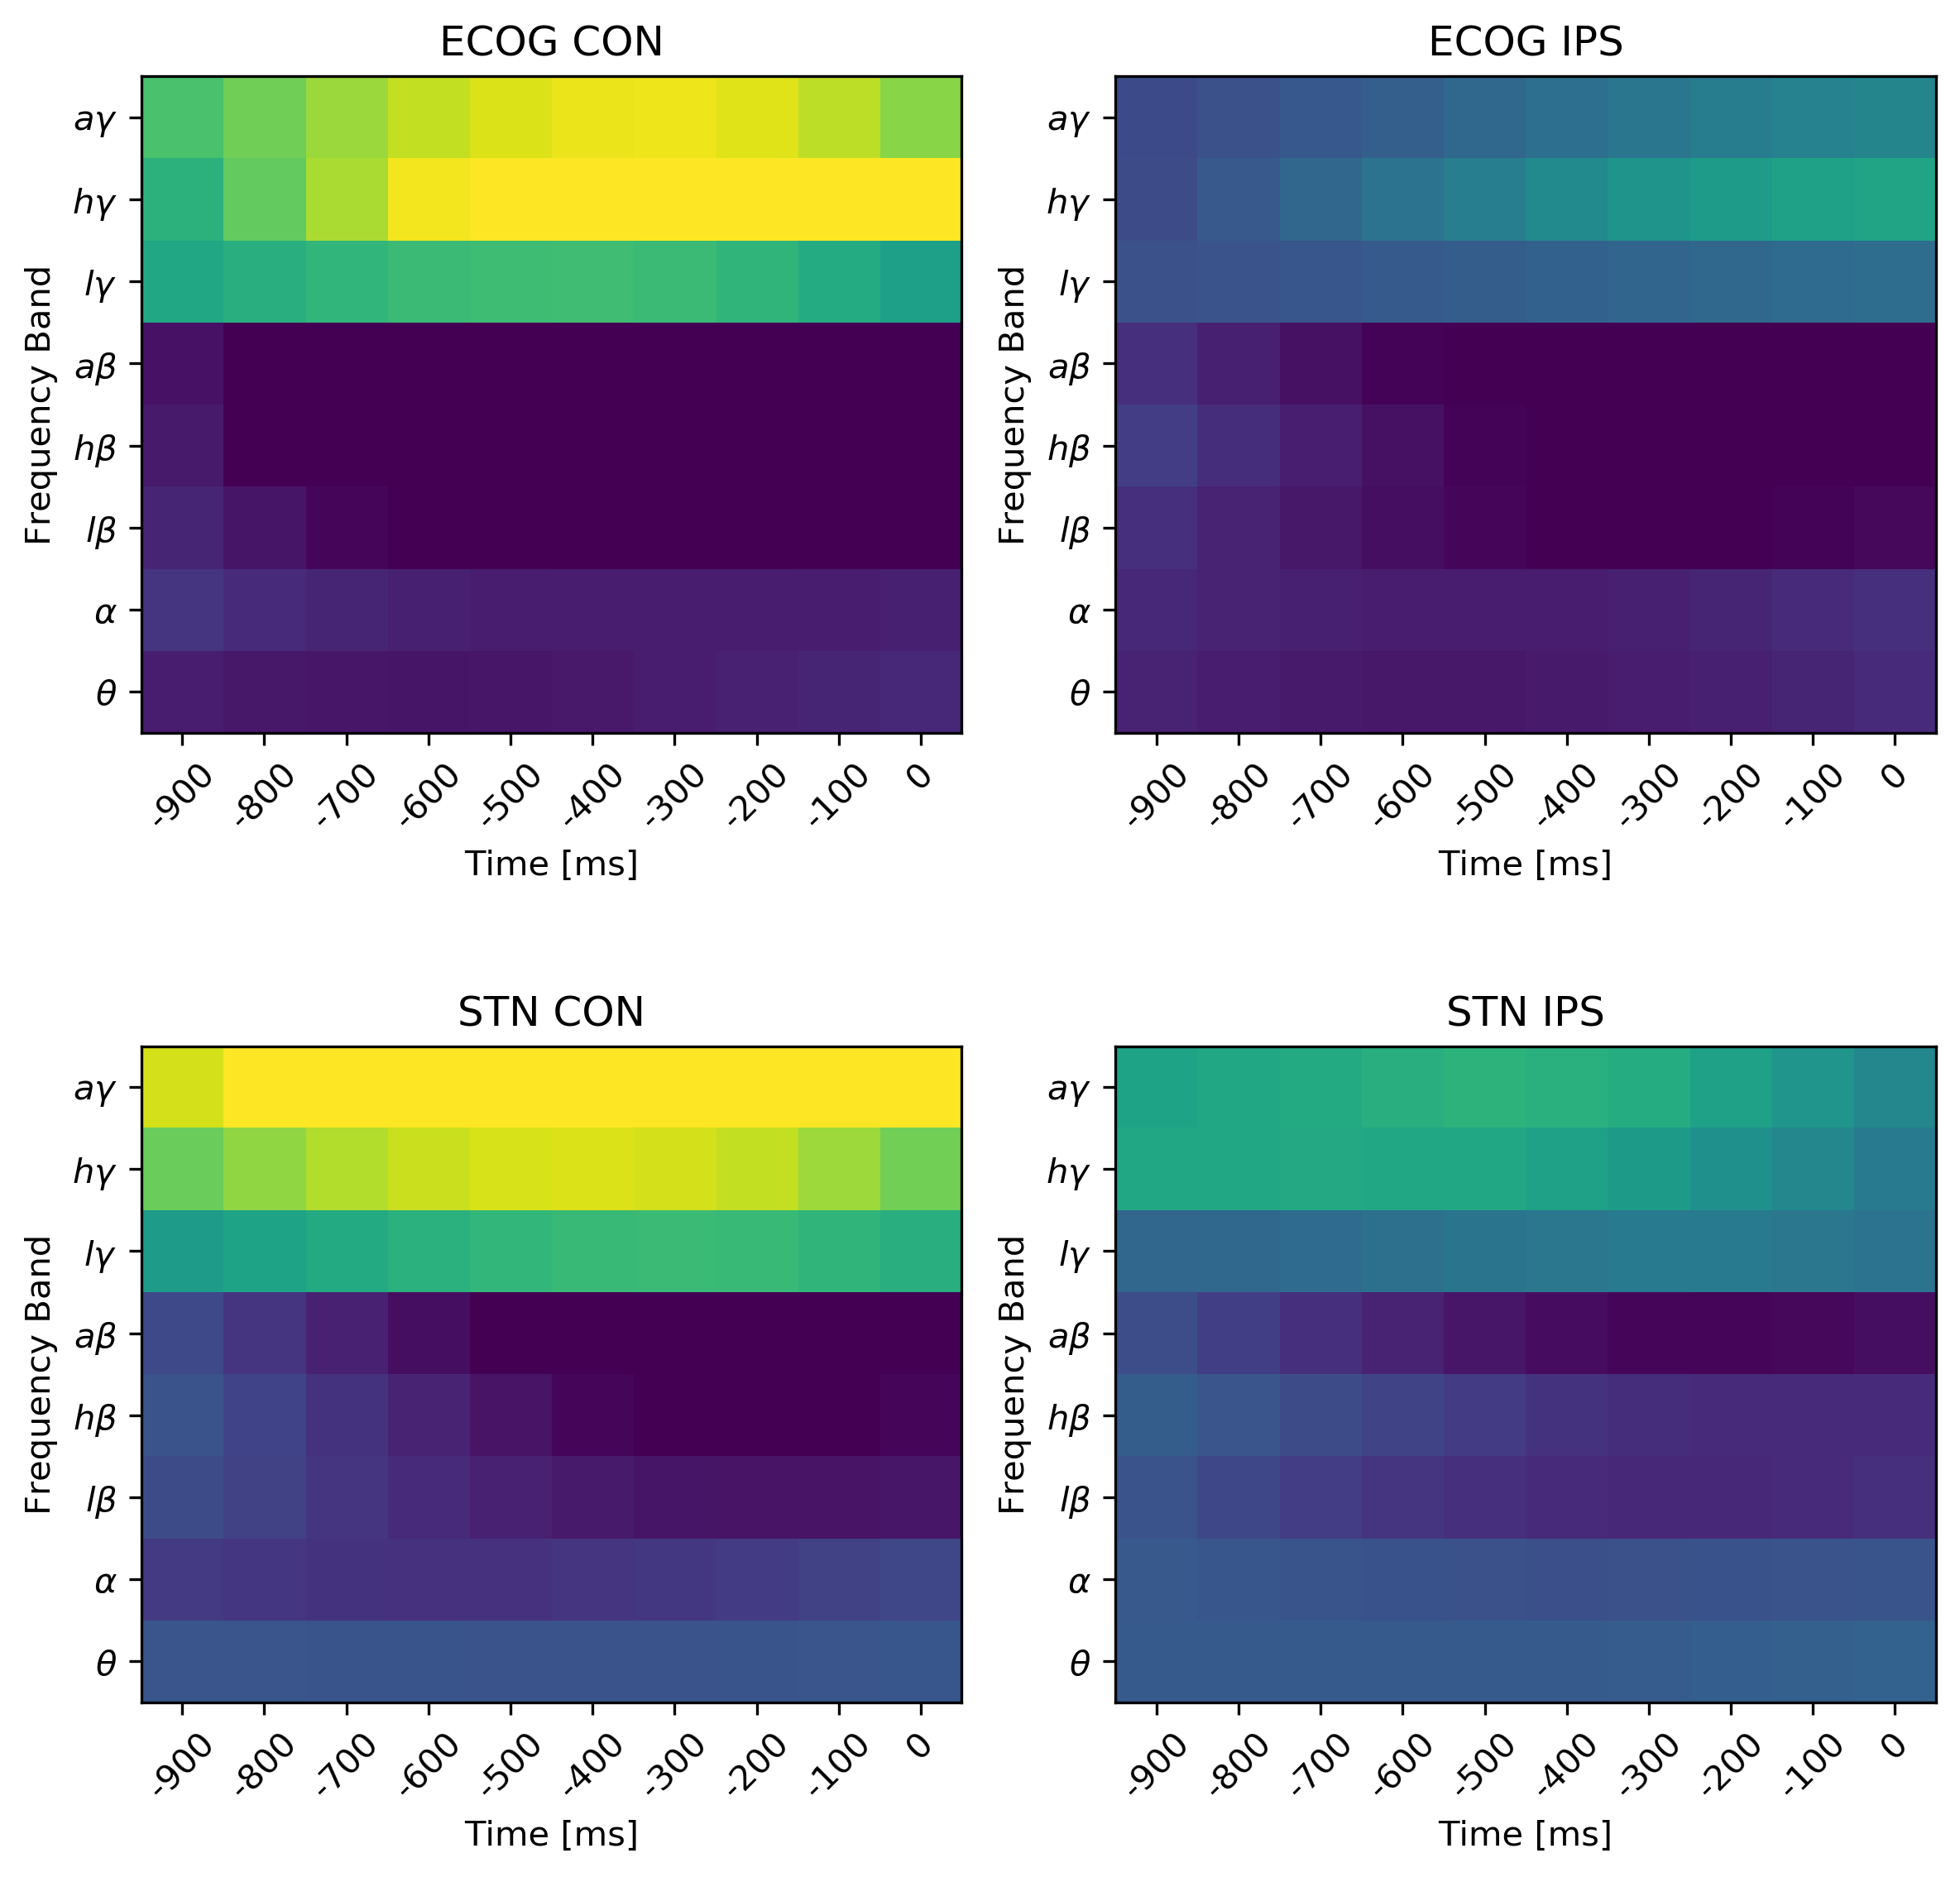

In [18]:
plt.figure(figsize=(6,6), dpi=300)
plt.subplot(2,2,1)
plot_weights(np.mean(ECOG_CON_weight, axis=0).T, 'ECOG CON')
plt.subplot(2,2,2)
plot_weights(np.mean(ECOG_IPS_weight, axis=0).T, 'ECOG IPS')
plt.subplot(2,2,3)
plot_weights(np.mean(STN_CON_weight, axis=0).T, 'STN CON')
plt.subplot(2,2,4)
plot_weights(np.mean(STN_IPS_weight, axis=0).T, 'STN IPS')
plt.tight_layout()